In [71]:
from IPython.core.display import HTML, display
from collections import namedtuple as NT

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as pl
from matplotlib import rcParams

from keras import models
from keras.layers import Dense, Conv1D, MaxPool1D
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from tqdm import tnrange, tqdm_notebook

In [2]:
display(HTML("<style>.container {width:90% !important}</style>"))

In [3]:
% matplotlib inline
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['axes.titlesize'] = 18
rcParams['figure.titlesize'] = 20

In [4]:
d_ = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_FullSet_noInteractions.pkl')

In [5]:
d_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 2 to 494
Data columns (total 28 columns):
oisst_s            162 non-null float64
solz_s             162 non-null float64
sat_rho_rc412_s    162 non-null float64
sat_rho_rc443_s    162 non-null float64
sat_rho_rc490_s    162 non-null float64
sat_rho_rc510_s    162 non-null float64
sat_rho_rc555_s    162 non-null float64
sat_rho_rc670_s    162 non-null float64
log10_etopo2_s     162 non-null float64
sin_doy_s          162 non-null float64
cos_doy_s          162 non-null float64
sin_minofday_s     162 non-null float64
cos_minofday_s     162 non-null float64
x_s                162 non-null float64
y_s                162 non-null float64
z_s                162 non-null float64
aphy411            162 non-null float64
aphy443            162 non-null float64
aphy489            162 non-null float64
aphy510            162 non-null float64
aphy555            162 non-null float64
aphy670            162 non-null float64
log10_aphy411  

In [6]:
X_sat = d_.dropna().filter(regex='sat')
y = d_.dropna().loc[:, 'log10_aphy%d' % band]

In [7]:
assert X_sat.shape[0] == y.size

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_sat, y, test_size=0.1, random_state=42)

In [12]:
def build_MLP_model(layers=1,n_hidden=256):
    model = models.Sequential()
    model.add(Dense(n_hidden, activation='relu', input_shape=(X_train.shape[1], )))
    if layers == 2:
        model.add(Dense(n_hidden, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def smooth(curve, points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

Given the small size of the data set, I will use k-fold validation to train the model.

{'fvm': [], 'fvmse': []}

In [95]:
def Cross_Fold_Validation(X_, y_, model_, k=4, num_epochs=100):
    results = dict(fold_val_mae=[], fold_val_mse=[],
                   val_mae_histories=[], train_mae_histories=[])
    kfold = KFold(n_splits=k, )
    for train_idx, val_idx in kfold.split(X_):
        history = model_.fit(X_[train_idx], y_[train_idx], epochs=num_epochs,
                            validation_data=(X_[val_idx], y_[val_idx]),
                            batch_size=1,  verbose=0)
        val_mse, val_mae = model_.evaluate(X_[val_idx], y_[val_idx], verbose=0)
        results['fold_val_mae'].append(val_mae)
        results['fold_val_mse'].append(val_mse)
        results['val_mae_histories'].append(history.history['val_mean_absolute_error'])
        results['train_mae_histories'].append(history.history['mean_absolute_error'])
    return results


def LOO_Validation(X_, y_, model_, num_epochs=100):
    results = dict(fold_val_mae=[], fold_val_mse=[],
                   val_mae_histories=[], train_mae_histories=[])
    loo = LeaveOneOut()
    for train_idx, val_idx in loo.split(X_):
        history = model_.fit(X_[train_idx], y_[train_idx], epochs=num_epochs,
                            validation_data=(X_[val_idx], y_[val_idx]),
                            batch_size=1, verbose=0)
        val_mse, val_mae = model_.evaluate(X_[val_idx], y_[val_idx], verbose=0)
        results['fold_val_mae'].append(val_mae)
        results['fold_val_mse'].append(val_mse)
        results['val_mae_histories'].append(history.history['val_mean_absolute_error'])
        results['train_mae_histories'].append(history.history['mean_absolute_error'])
    return results


def plot_mae_history(train_mae_history, val_mae_history):
    avg_val_mae_history = [np.mean([x[i] for x in val_mae_histories])
                           for i in range(num_epochs)]
    avg_train_mae_history = [np.mean([x[i] for x in train_mae_histories])
                           for i in range(num_epochs)]
    pl.plot(range(1, len(avg_val_mae_history) + 1), avg_val_mae_history, label='val')
    pl.plot(range(1, len(avg_train_mae_history) + 1), avg_train_mae_history, label='train',
           color='r')
    pl.xlabel('Epochs')
    pl.ylabel('MAE');
    
def plot_fits(model_,):
    y_pred = model_.predict(X_test)
    _, ax = pl.subplots(figsize=(10, 10))
    r2_  = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred, )
    min_ = min(y_pred.min(), y_test.min())
    max_ = max(y_pred.max(), y_test.max())
    ax.plot([min_, max_],[min_, max_], ls='--', color='k', label='1:1')
    ax.scatter(y_pred, y_test, label='$r^2$ = %.2f, mae = %.2f' %(r2_, mae))
    ax.set_xlabel('predicted')
    ax.set_ylabel=('observed')
    ax.legend()
    ax.set_title('MLP - Test Data')

    
def plot_fits_2(model_,):
    y_pred = model_.predict(X_test.values)
    ix = np.argsort(y_test)
    xi = np.arange(ix.size)
    _, ax = pl.subplots(figsize=(12, 8))
    ax.scatter(xi, y_test.values[ix], color='steelblue', edgecolor='k', s=50, label='observed')
    ax.scatter(xi, y_pred[ix], color='m', edgecolor='k', s=50, label='predicted')
    ax.legend();

### Single Layer Models
#### 1. <u>4-Fold Cross-Validation</u>

In [67]:
model_L1NN_KCV = build_MLP_model()

In [68]:
X_train_ = X_train.values
y_train_ = y_train.values

In [76]:
results_l1nn_kcv = Cross_Fold_Validation(X_train_, y_train_, model_=model_L1NN_KCV)

In [80]:
results_l1nn_kcv['fold_val_mae']

[0.07534899623007388,
 0.08488730920685662,
 0.11243537978993522,
 0.07854123910268147]

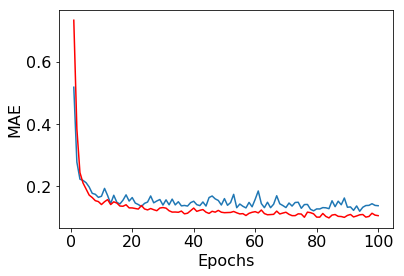

In [82]:
plot_mae_history(results_l1nn_kcv['train_mae_histories'], results_l1nn_kcv['val_mae_histories'])

In [84]:
test_mse_score, test_mae_score = model_L1NN_KCV.evaluate(X_test, y_test)
np.sqrt(test_mse_score), test_mae_score

17/17 [==============================] - 0s 55us/step


(0.110088905080065, 0.09527956694364548)

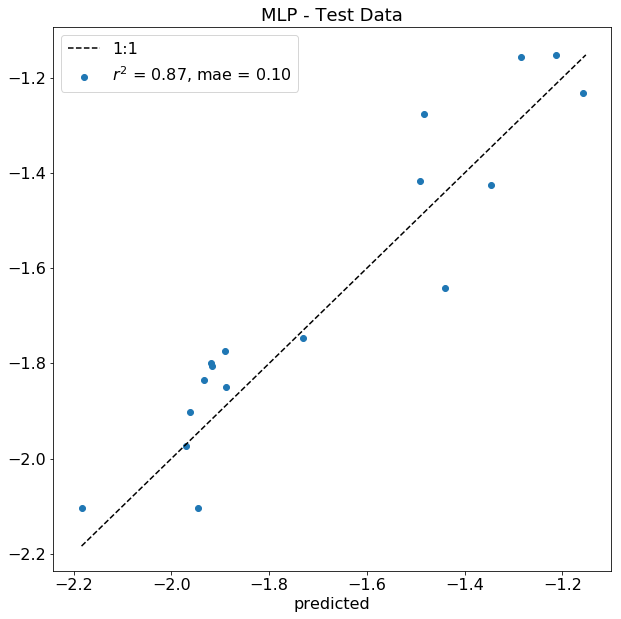

In [86]:
plot_fits(model_L1NN_KCV, X_test)

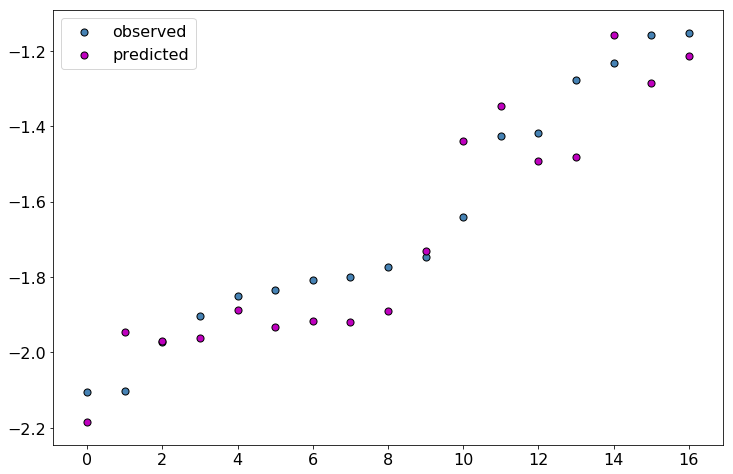

In [92]:
plot_fits_2(model_L1NN_KCV)

In [93]:
model_L1NN_KCV.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 256)               1792      
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 257       
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


#### 2. <u>Leave-One-Out Cross-Validation</u>

In [ ]:
model_L1NN_LOO = build_MLP_model()
results_l1nn_loo = LOO_Validation(X_train_, y_train_, model_=model_L1NN_LOO)

In [ ]:
results_l1nn_kcv['fold_val_mae'], results_l1nn_loo['fold_val_mae']

In [ ]:
plot_mae_history(results_l1nn_loo['train_mae_histories'], results_l1nn_loo['val_mae_histories'])

In [ ]:
test_mse_score_loo, test_mae_score_loo = model_L1NN_LOO.evaluate(X_test, y_test)
np.sqrt(test_mse_score_loo), test_mae_score_loo